# Models and small data

## TF2 setup

In [1]:
!pip install tf-nightly-gpu-2.0-preview

In [2]:
import tensorflow as tf

print(tf.version.VERSION)
print(tf.test.is_gpu_available())

%load_ext tensorboard

2.0.0-dev20190527
True


In [0]:
import datetime, os

import numpy as np
from matplotlib import pyplot as plt

In [0]:
TARGET_SIZE = [192, 192]
# TODO: clean-up IMAGE_SIZE
IMAGE_SIZE = TARGET_SIZE

DATASET_FOLDER = './dataset/tfrec/'

CLASSES = [b'converse chuck 70', b'Exaggerated Soles', b'nike air max 90 essentials', b'nike react', b'Tie Dye sneakers']

In [0]:
# @title display utilities [RUN ME]

def display_one_image(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(label.numpy().decode("utf-8"), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])
  
def title_from_label_and_target(predicted_class, target_class):
  """Generate a label based on the match between predicted and target"""
  correct = (predicted_class == target_class)
  
  result = "{} [{}{}{}]".format(CLASSES[predicted_class].decode('utf8'), str(correct), ',\n shoud be ' if not correct else '',
                              CLASSES[target_class] if not correct else ''), correct
  
  return result


def display_9_images_with_predictions(images, predictions, class_targets):
  """Generate 3x3 grid of predictions with labels / targets"""
  
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  class_targets = class_targets.numpy()

  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], class_targets[i])
    subplot = display_one_image(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

## Read data

In [0]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64),   # shape [] means scalar
        
        # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
        "label":         tf.io.FixedLenFeature([], tf.string),  # one bytestring
        "size":          tf.io.FixedLenFeature([2], tf.int64),  # two integers
        "one_hot_class": tf.io.VarLenFeature(tf.float32)        # a certain number of floats
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding
    
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    
    class_num = example['class']
    
    label  = example['label']
    height = example['size'][0]
    width  = example['size'][1]
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    return image, class_num, label, height, width, one_hot_class
    
# read from TFRecords. For optimal performance, use "interleave(tf.data.TFRecordDataset, ...)"
# to read from multiple TFRecord files at once and set the option experimental_deterministic = False
# to allow order-altering optimizations.

option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False

raw_data = tf.data.Dataset.list_files(DATASET_FOLDER + "*.tfrec")
raw_data = raw_data.with_options(option_no_order)
#raw_data = tf.data.TFRecordDataset(filenames, num_parallel_reads=16)
raw_data = raw_data.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=tf.data.experimental.AUTOTUNE)
raw_data = raw_data.map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)

display_dataset = raw_data.map(lambda image, class_num, label, height, width, one_hot_class: (image, label))

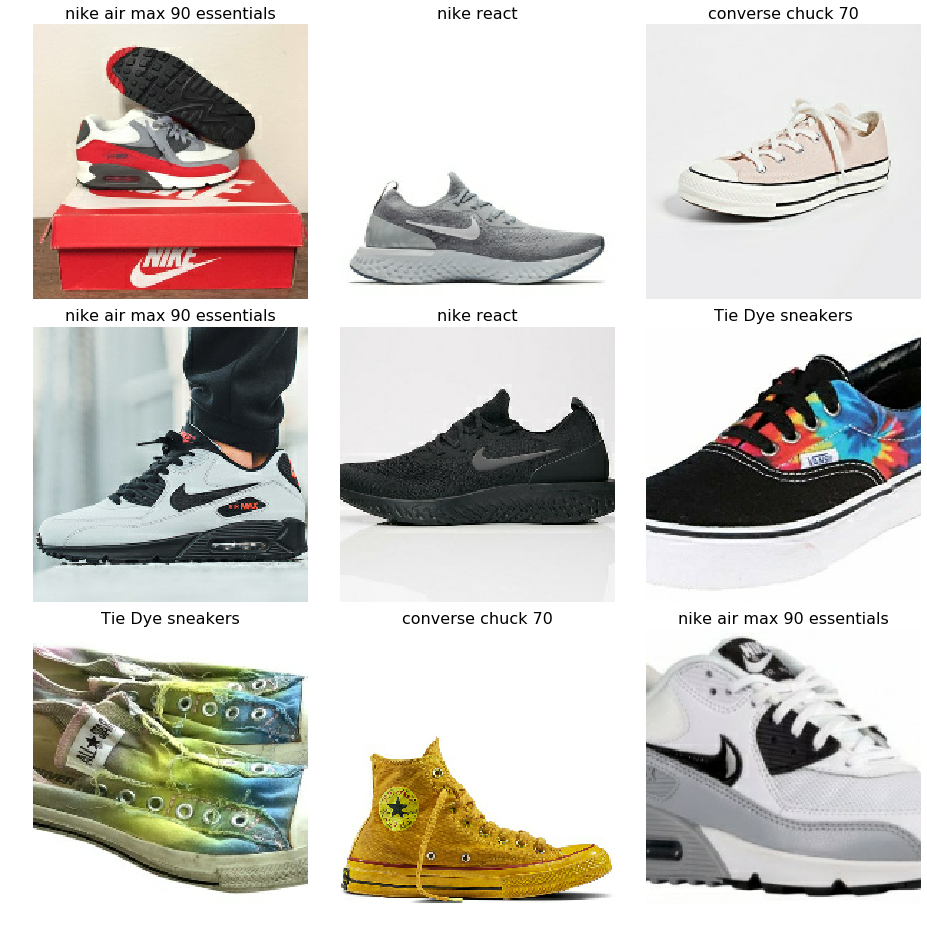

In [7]:
display_9_images_from_dataset(display_dataset)

## Model

### training and validation datasets

In [0]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

# steps_per_epoch = int(3670 // len(filenames) * len(training_filenames)) // BATCH_SIZE
steps_per_epoch = 210 // BATCH_SIZE
EPOCHS = 1



train_dataset = raw_data.map(lambda image, class_num, label, height, width, one_hot_class: (image, one_hot_class))

train_batches = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [9]:
for image_batch, label_batch in train_batches.take(1):
  print(image_batch.shape, label_batch.shape)
  
print(label_batch[0].numpy())

(32, 192, 192, 3) (32, 5)
[0. 0. 0. 0. 1.]


### Raw data

In [10]:
for data, label in train_batches.take(1):
  print(data.shape)
  print(data[0])

(32, 192, 192, 3)
tf.Tensor(
[[[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [254 255 253]
  [253 255 252]
  [254 255 253]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [254 255 255]
  [252 254 251]
  [254 255 253]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [255 255 255]
  [252 252 252]
  [252 252 252]]

 ...

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]], shape=(192, 192, 3), dtype=uint8)


### Normalize data for better training

The image data is raw, values from 1 to 255. There are different ways to normalize such data.

One way to solve this with `tf.keras.preprocessing.image.ImageDataGenerator`

```
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)
```


In [0]:
def normalize_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  return image, label

In [0]:
train_normalized_dataset = raw_data.map(lambda image, class_num, label, height, width, one_hot_class: (image, one_hot_class)).map(normalize_example)
train_normalized_batches = train_normalized_dataset.shuffle(SHUFFLE_BUFFER_SIZE).repeat().batch(BATCH_SIZE)



In [13]:
for data, label in train_normalized_batches.take(1):
  print(data.shape)
  print(data[0])

(32, 192, 192, 3)
tf.Tensor(
[[[-0.01176471 -0.06666666 -0.19215685]
  [-0.00392157 -0.05882353 -0.18431371]
  [ 0.00392163 -0.06666666 -0.18431371]
  ...
  [-0.03529412 -0.10588235 -0.2235294 ]
  [-0.00392157 -0.0745098  -0.19215685]
  [ 0.03529418 -0.03529412 -0.15294117]]

 [[ 0.01176476 -0.04313725 -0.16862744]
  [ 0.00392163 -0.05098039 -0.17647058]
  [-0.01176471 -0.08235294 -0.19999999]
  ...
  [-0.01176471 -0.08235294 -0.19999999]
  [ 0.0196079  -0.05098039 -0.16862744]
  [ 0.05882359 -0.01176471 -0.12941176]]

 [[ 0.05882359 -0.01176471 -0.12941176]
  [ 0.02745104 -0.02745098 -0.15294117]
  [-0.01176471 -0.06666666 -0.19215685]
  ...
  [-0.01176471 -0.08235294 -0.19999999]
  [ 0.01176476 -0.05882353 -0.17647058]
  [ 0.03529418 -0.03529412 -0.15294117]]

 ...

 [[-0.7411765  -0.81960785 -0.8901961 ]
  [-0.12156862 -0.19215685 -0.32549018]
  [ 0.32549024  0.27058828  0.06666672]
  ...
  [-0.06666666 -0.09803921 -0.29411763]
  [ 0.04313731 -0.04313725 -0.21568626]
  [ 0.1686275  

In [0]:
test_batches = raw_data.map(lambda image, class_num, label, height, width, one_hot_class: (image, one_hot_class)).map(normalize_example).batch(BATCH_SIZE)

### The simples Network

In [0]:
# TODO: replace to number of classes in last layer

def create_model_simplest():
  model = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape=[*IMAGE_SIZE, 3]),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(256, activation='relu'),
      
      tf.keras.layers.Dense(5, activation='softmax')
  ])

  model.compile(
      optimizer=tf.keras.optimizers.Adam(),
      loss = 'categorical_crossentropy',
      metrics=['accuracy']
  )

  model.summary()
  
  return model

In [17]:
model = create_model_simplest()

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


model.fit(train_normalized_batches, steps_per_epoch=steps_per_epoch, epochs=10,
          validation_data=test_batches, validation_steps=steps_per_epoch,
          callbacks=[tensorboard_callback])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 110592)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               56623616  
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 1285      
Total params: 57,018,885
Trainable params: 57,018,885
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


W0528 00:12:04.635190 139748434331520 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


1/6 [====>.........................] - ETA: 10s - loss: 1.8924 - accuracy: 0.1250

W0528 00:12:06.270610 139748434331520 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (0.164306). Check your callbacks.


6/6 [==============================] - 7s 1s/step - loss: 10.9412 - accuracy: 0.1875 - val_loss: 12.5083 - val_accuracy: 0.2240
Epoch 2/10
6/6 [==============================] - 5s 783ms/step - loss: 12.3404 - accuracy: 0.2344 - val_loss: 12.5083 - val_accuracy: 0.2240
Epoch 3/10
6/6 [==============================] - 4s 715ms/step - loss: 12.4244 - accuracy: 0.2292 - val_loss: 12.5083 - val_accuracy: 0.2240
Epoch 4/10
6/6 [==============================] - 4s 717ms/step - loss: 12.8441 - accuracy: 0.2031 - val_loss: 12.5083 - val_accuracy: 0.2240
Epoch 5/10
6/6 [==============================] - 4s 713ms/step - loss: 11.9207 - accuracy: 0.2604 - val_loss: 12.5083 - val_accuracy: 0.2240
Epoch 6/10
6/6 [==============================] - 4s 720ms/step - loss: 13.0120 - accuracy: 0.1927 - val_loss: 12.5083 - val_accuracy: 0.2240
Epoch 7/10
6/6 [==============================] - 4s 708ms/step - loss: 13.0120 - accuracy: 0.1927 - val_loss: 12.5083 - val_accuracy: 0.2240
Epoch 8/10
6/6 [====

### Convolutional Neural Network


In [0]:
# TODO: replace to number of classes in last layer

def create_model_cnn():
  
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=[*IMAGE_SIZE, 3]))
  model.add(tf.keras.layers.MaxPooling2D((2, 2)))
  model.add(tf.keras.layers.Dropout(0.4))
  
  model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D((2, 2)))
  model.add(tf.keras.layers.Dropout(0.4))
  
  model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
  
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(64, activation='relu'))
  model.add(tf.keras.layers.Dense(5, activation='softmax'))
  

  model.compile(
      optimizer=tf.keras.optimizers.Adam(),
      loss = 'categorical_crossentropy',
      metrics=['accuracy']
  )

  model.summary()
  
  return model


In [19]:
cnn_model = create_model_cnn()

logdir = os.path.join("logs", "cnn", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


cnn_model.fit(train_normalized_batches, steps_per_epoch=steps_per_epoch, epochs=20,
              validation_data=test_batches, validation_steps=steps_per_epoch,
              callbacks=[tensorboard_callback])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 190, 190, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 95, 95, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 95, 95, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 93, 93, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)       

### Transfer learning

Based on Keras models


We can also decide depending on amount of data if we use base network for just feature extraction.

In [0]:
# TODO: replace to number of classes in last layer

def create_model_app(base_model):
  model = tf.keras.Sequential([
      base_model,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(5, activation='softmax')
  ])

  model.compile(
      optimizer=tf.keras.optimizers.Adam(),
      loss = 'categorical_crossentropy',
      metrics=['accuracy']
  )

  model.summary()
  
  return model

In [21]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
#pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
pretrained_model.trainable = False

model_app = create_model_app(base_model=pretrained_model)

logdir = os.path.join("logs", "app", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


model_app.fit(train_normalized_batches, steps_per_epoch=steps_per_epoch, epochs=25,
              validation_data=test_batches, validation_steps=steps_per_epoch,
              callbacks=[tensorboard_callback])

  

9412608/9406464 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/25
6/6 [==============================] - 5s 909ms/step - loss: 1.7720 - accuracy: 0.2448 - val_loss: 1.6861 - val_accuracy: 0.2812
Epoch 2/25
6/6 [===================

In [22]:
%tensorboard --logdir logs

Alternatively we can also fine-tune the weights of original network

```python
pretrained_model.trainable = True
```

In [23]:
pretrained_model.trainable = True

print(f"Number of trainable weights for base model: {len(pretrained_model.trainable_weights)}")

create_model_app(base_model=pretrained_model)

Number of trainable weights for base model: 156
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 2,230,277
Non-trainable params: 34,112
_________________________________________________________________


Or even more advanced when you can set what weights to configure

In [24]:
# Let's take a look to see how many layers are in the base model
print(f"Number of layers in the base model: {len(pretrained_model.layers)}")

# Fine tune from this layer onwards
fine_tune_at = 128

# Freeze all the layers before the `fine_tune_at` layer
for layer in pretrained_model.layers[:fine_tune_at]:
    layer.trainable =  False
  
print(f"Number of trainable weights {len(pretrained_model.trainable_weights)}")

Number of layers in the base model: 155
Number of trainable weights 27


In [25]:
model = create_model_app(base_model=pretrained_model)
len(model.trainable_variables)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 1,376,965
Non-trainable params: 887,424
_________________________________________________________________


29

### Transfer learning TF-hub

In [26]:
!pip install tensorflow_hub

In [27]:
import tensorflow_hub as tfhub

print(tfhub.version.__version__)

0.4.0


In [0]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}


Can be set as trainable or not

```python
feature_extractor_layer.trainable = False
```

In [0]:
# WARNING: just an example in real life is super slow 
# since we resize as a part of layer computations

def create_model_tfhub():
  model = tf.keras.Sequential([
      tf.keras.layers.Lambda( 
          lambda image: tf.image.resize( 
              image, 
              (224, 224), 
              method = tf.image.ResizeMethod.BICUBIC
          ),
      input_shape=(192, 192, 3)),
      tfhub.KerasLayer(feature_extractor_url),
      tf.keras.layers.Dense(5, activation='softmax')
  ])
  

  model.compile(
      optimizer=tf.keras.optimizers.Adam(),
      loss = 'categorical_crossentropy',
      metrics=['accuracy']
  )

  model.summary()
  
  return model

In [30]:
model_hub = create_model_tfhub()

logdir = os.path.join("logs", "hub", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


model_hub.fit(train_normalized_batches, steps_per_epoch=steps_per_epoch, epochs=25,
              validation_data=test_batches, validation_steps=steps_per_epoch,
              callbacks=[tensorboard_callback])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 224, 224, 3)       0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/25
6/6 [==============================] - 6s 923ms/step - loss: 1.8535 - accuracy: 0.2240 - val_loss: 1.9624 - val_accuracy: 0.1719
Epoch 2/25
6/6 [==============================] - 1s 233ms/step - loss: 1.5695 - accuracy: 0.3542 - val_loss: 1.6443 - val_accuracy: 0.3021
Epoch 3/25
6/6 [==============================] - 1s 245ms/step - loss: 1.2820 - accuracy:

## Predictions

In [0]:
selected_model = model_hub

tf.Tensor([4 0 0 0 2 2 2 0 4 4 2 4 3 4 3 2 2 2 0 1 0 1 2 2 4 1 1 1 0 4 3 0], shape=(32,), dtype=int64)


W0528 00:15:07.319129 139748434331520 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0528 00:15:07.337905 139748434331520 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0528 00:15:07.355190 139748434331520 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0528 00:15:07.372316 139748434331520 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0528 00:15:07.391799 139748434331520 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0528 00:15:07.411506 139748434331520 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0528 00:15:07.428639 139748

predictions classes: [4 0 0 0 2 2 2 0 4 4 2 4 3 4 3 2 2 2 0 1 0 1 2 2 4 1 1 1 0 4 3 0]
errors: []


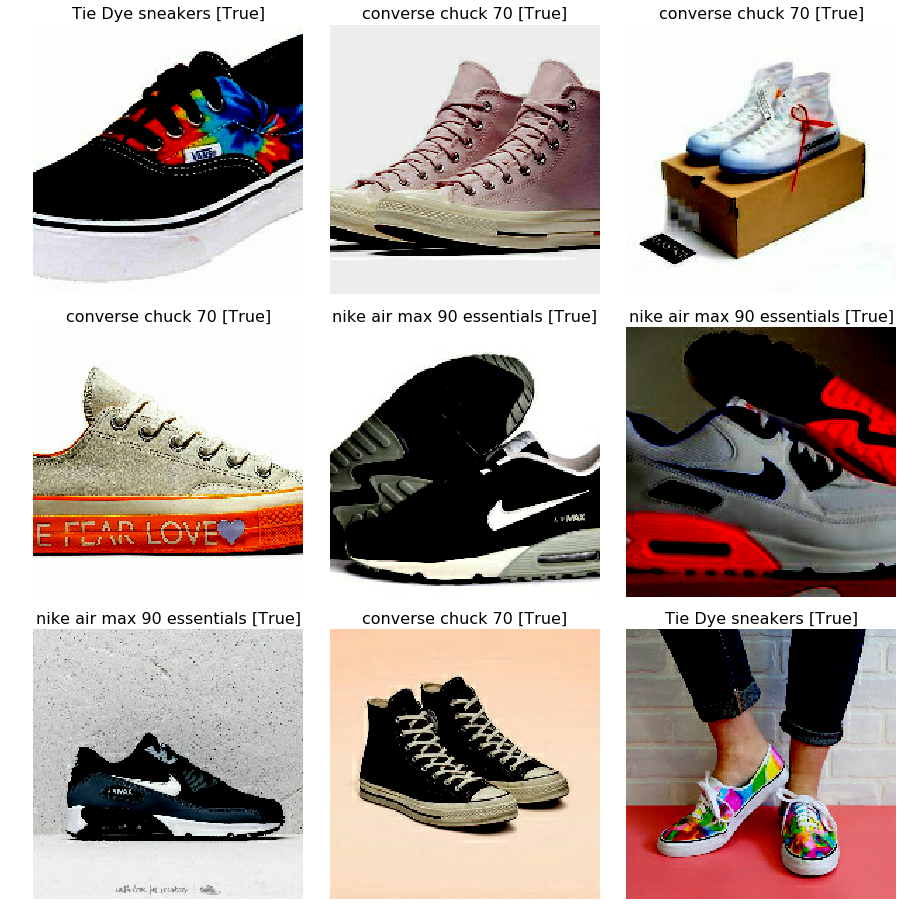

In [32]:
# TODO: replace this with real test dataset

test_dataset = raw_data.map(lambda image, class_num, label, height, width, one_hot_class: (image, class_num)).map(normalize_example)


for kicks, class_target in test_dataset.shuffle(SHUFFLE_BUFFER_SIZE).repeat().skip(np.random.randint(1, 512)).batch(BATCH_SIZE).take(1):
  print(class_target)
  
  predictions_raw = selected_model.predict(kicks, steps=1)
  
# print(f"raw predictions: {predictions_raw}")

predictions_classes = np.argmax(predictions_raw, axis=-1)
print(f"predictions classes: {predictions_classes}")


errors = [(prediction, class_target[idx].numpy()) for idx, prediction in enumerate(predictions_classes[:9]) if prediction != class_target[idx].numpy()]
print(f"errors: {errors}")

display_9_images_with_predictions(kicks, predictions_raw, class_target)


### Evaluation

In [0]:
test_batches = raw_data.map(lambda image, class_num, label, height, width, one_hot_class: (image, one_hot_class)).map(normalize_example).batch(BATCH_SIZE)
test_labels = raw_data.map(lambda image, class_num, label, height, width, one_hot_class: (class_num)).batch(BATCH_SIZE)

In [0]:
from sklearn.metrics import confusion_matrix

predictions = np.argmax(selected_model.predict(test_batches), axis=-1)

# TODO: make it proper way
# super ugly way to map dataset of labels to confusion matrix

for test in raw_data.map(lambda image, class_num, label, height, width, one_hot_class: (class_num)).batch(210).take(210):
  target_labels = test.numpy()
  
  
cm = confusion_matrix(target_labels, predictions)

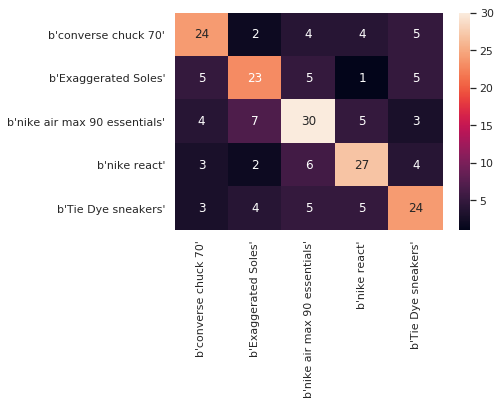

In [35]:
import seaborn as sns; sns.set()

confusion_matrix = sns.heatmap(cm, annot=True, fmt="d", yticklabels=CLASSES, xticklabels=CLASSES)
confusion_matrix.set_xticklabels(confusion_matrix.get_xticklabels(), rotation = 90)

confusion_matrix

## Save model

In [0]:
!mkdir models

In [0]:
# Supporting in place is still experimaental
selected_model.save('./models/model_transfered_mobilenet.h5', save_format='h5')

# We could also store the bare minimum with `serving_only=False`
tf.keras.experimental.export_saved_model(selected_model, './models/model_transfered_mobilenet')

In [0]:
!ls -laF models

## Links


*   https://www.tensorflow.org/alpha/tutorials/images/intro_to_cnns
*   https://www.tensorflow.org/alpha/tutorials/images/hub_with_keras
*   https://www.tensorflow.org/alpha/tutorials/images/transfer_learning
*   https://www.tensorflow.org/tensorboard/r2/tensorboard_in_notebooks
*   https://www.tensorflow.org/alpha/tutorials/images/hub_with_keras

